## AIPI 590 - XAI | Assignment #3
### Interpretable ML
#### Author: Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/notthattal/AdversarialAI_Patch/blob/main/adversarial_patch.ipynb#scrollTo=jv7U4G4FodQf)

### How to Run in Colab

1. Verify you are running on a GPU. On the top right of the screen click the down arrow in between "RAM/Disk" and "Gemini"  -> Change Runtime Type -> T4 GPU -> Save
2. Ensure Environment Variables are set/Set Environment Variables. On the left-hand side of the screen click the key -> Add new secret -> set the following environment variables:
    - CHECKPOINT_PATH: /content/AdversarialAI_Patch/saved_models/
    - DATASET_PATH: /content/AdversarialAI_Patch/data/
    - IMAGE_PATH: /content/AdversarialAI_Patch/saved_models/images/
    - TORCH_HOME: /content/AdversarialAI_Patch/saved_models/
3. For each environment variable make sure notebook access is activated (a switch located to the left-hand side of each individual environment variable)

### Introduction

This notebook uses a [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code) database.

### Install required dependencies and import required packages

In [2]:
!pip install -r requirements.txt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pygam import LinearGAM, LogisticGAM, s
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

You should consider upgrading via the '/Users/talerez/Documents/AIPI_590_XAI/Interpretable_ML/venv/bin/python3 -m pip install --upgrade pip' command.


### Preparing the Dataframe
1. Creates a dataframe from the CSV
2. Cleans the dataframe by dropping all rows with empty strings, whitespace-only strings and NaN values
3. Converts all the "Yes/No" categorical columns to binary 1 or 0
4. One-hot encodes the non-binary categorical columns and drops duplicate one-hot encoded columns (e.g. 'OnlineBackup_No internet service and 'DeviceProtection_No internet service' would just become "No Internet Service")
5. Remove the Customer ID column from the dataframe as this feature should not affect the outcome
6. Convert the boolean columns from the one-hot-encoding to integers and the totalCharges column to a float instead of an object
7. Assign the feature columns to X and the target column to y

In [4]:
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Strip any whitespace from the column (important for cases with invisible spaces)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Replace all empty strings and whitespace-only strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Drop rows with any NaN or empty string
df = df.dropna()

# Convert all binary columns to integers False = 0 and True = 1 
yes_no_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for i in yes_no_cols:
    df[i] = df[i].map({'No': 0, 'Yes': 1})
df["gender"] = df["gender"].map({'Male': 0, 'Female': 1})

#One hot encode dataframe
df = pd.get_dummies(df, columns=["MultipleLines", "OnlineSecurity", "OnlineBackup", 
                                 "DeviceProtection", "TechSupport", "StreamingTV", 
                                 "StreamingMovies", "InternetService", "Contract", 
                                 "PaymentMethod"], drop_first=True)

#Drop columns that are essentially duplicates of another column in the df
df = df.drop(columns=['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service'])

#remove the ID column as it we will not need it for regression
cleaned_df = df.drop(columns=['customerID'])

#convert the TotalCharges column from string to float
cleaned_df['TotalCharges'] = df['TotalCharges'].astype(float)

#convert all boolean columns to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == 'bool':  # Check for boolean dtype
        cleaned_df[col] = cleaned_df[col].astype(int)

scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
cleaned_df[scale_cols] = scaler.fit_transform(cleaned_df[scale_cols])

y = cleaned_df["Churn"]
X = cleaned_df.drop(columns=["Churn"])

### Assessing Linearity
According to this [source](https://bookdown.org/rwnahhas/RMPH/mlr-linearity.html) linearity is assumed for all cases in which the target is binary. Thus, for our case in regards to Churn, the Linearity assumption has been met.

### Assessing Independence

Independence of observations for this dataset is assumed due to each row consisting of an individual user and one user's plan shouldn't influence another's plan.

### Assessing MultiCollinearity

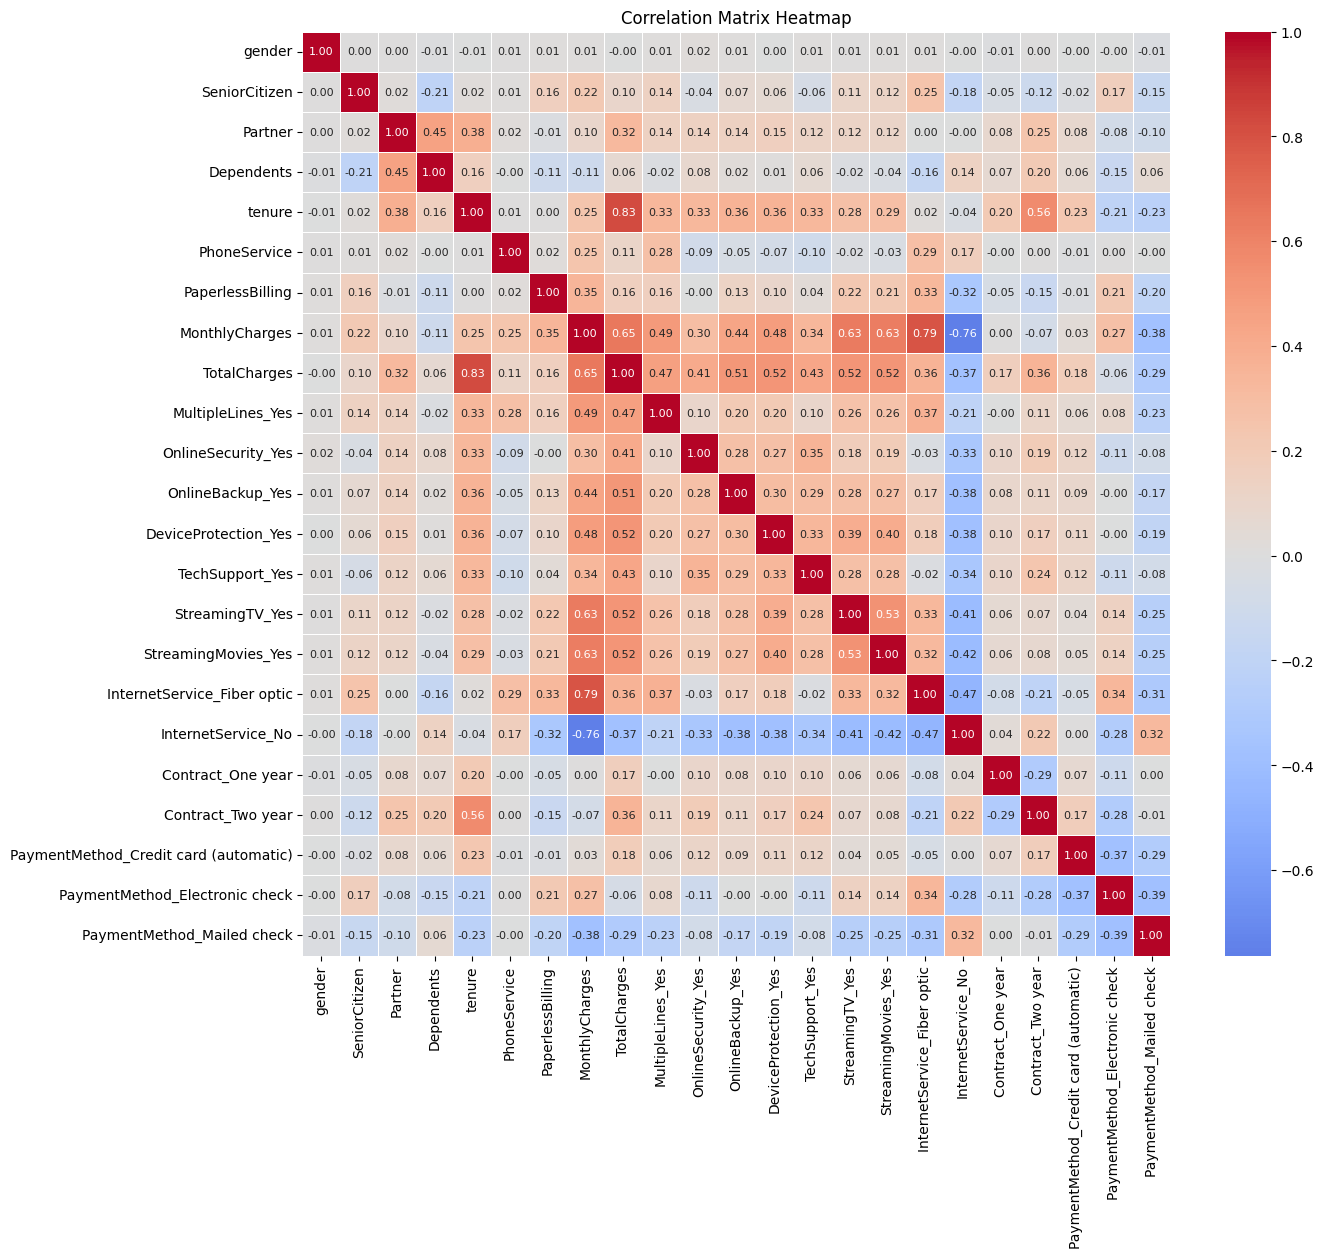

In [5]:
# Calculate correlation matrix
corr_matrix = X.corr()

plt.figure(figsize=(14, 12))  # Adjust the figure size for readability

# Step 3: Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", annot_kws={"size": 8}, cmap='coolwarm', center=0, linewidths=0.5)


# Step 4: Add labels and title
plt.title('Correlation Matrix Heatmap')
plt.show()

### Visualizing MultiCollinearity using VIF (using a threshold of 10)
https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

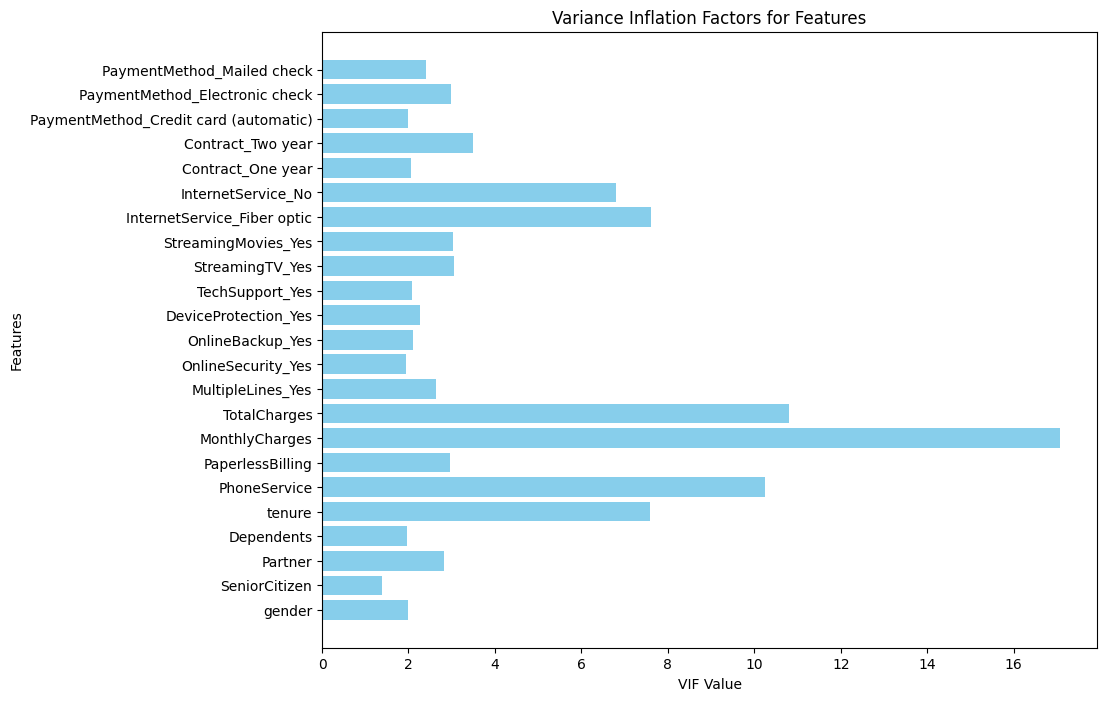

In [6]:
# Create a DataFrame to store VIF values
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.barh(vif['Feature'], vif['VIF'], color='skyblue')
plt.xlabel('VIF Value')
plt.ylabel('Features')
plt.title('Variance Inflation Factors for Features')
plt.show()


### As we can see monthly charges has a very high multicollinearity score, let's visualize it better

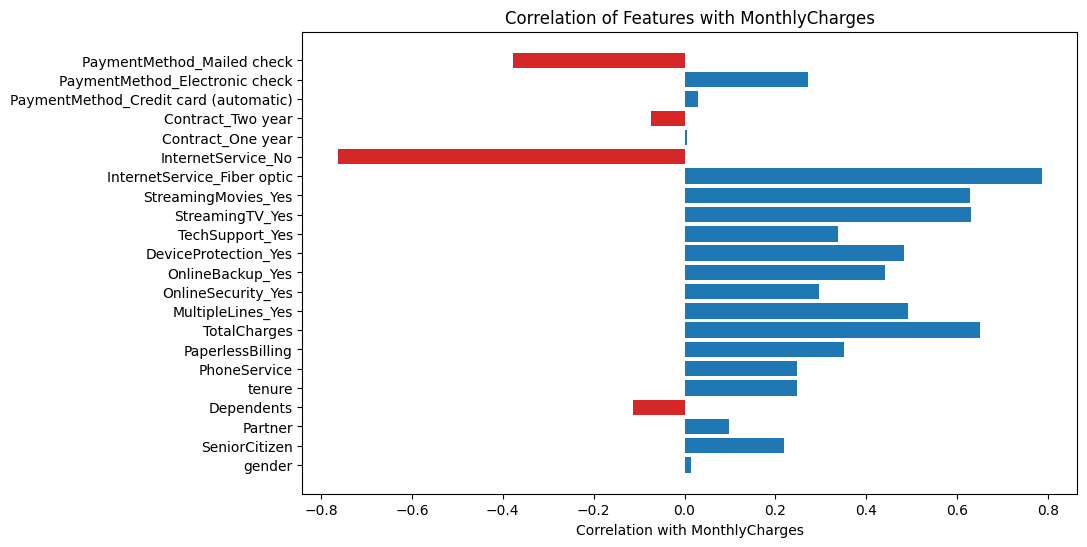

In [7]:
correlation_matrix = X.corr()
corr_with_monthly = correlation_matrix['MonthlyCharges'].drop('MonthlyCharges')  # Drop 'MonthlyCharges' correlation with itself

# Step 3: Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(corr_with_monthly.index, corr_with_monthly.values, color=['#1f77b4' if x > 0 else '#d62728' for x in corr_with_monthly])

# Step 4: Add labels and title
plt.xlabel('Correlation with MonthlyCharges')
plt.title('Correlation of Features with MonthlyCharges')

# Step 5: Display the plot
plt.show()

### What to do about the monthly charge problem?
This problem is actually two-fold. First, after dropping the monthly charge column and re-evaluating the VIF, I found the total charges and tenure were still above the threshold of 10 we set. This makes sense, as the longer a person stays with the company the higher the total charges would be. They are directly correlated. In order to meet our threshold, I chose to drop the monthly charges and tenure columns. Monthly charges can be correlated to many other features such as if the customer pays for fiber optics, phone service etc. Let's drop the columns discussed and see how it affects our VIF.

In [8]:
X = X.drop(columns=["MonthlyCharges", 'tenure'])

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                                  Feature       VIF
0                                  gender  1.929593
1                           SeniorCitizen  1.356549
2                                 Partner  2.719081
3                              Dependents  1.966007
4                            PhoneService  9.888234
5                        PaperlessBilling  2.780106
6                            TotalCharges  3.057348
7                       MultipleLines_Yes  2.509934
8                      OnlineSecurity_Yes  1.937840
9                        OnlineBackup_Yes  2.097387
10                   DeviceProtection_Yes  2.248736
11                        TechSupport_Yes  2.066252
12                        StreamingTV_Yes  2.680695
13                    StreamingMovies_Yes  2.699713
14            InternetService_Fiber optic  3.861423
15                     InternetService_No  3.295693
16                      Contract_One year  1.832328
17                      Contract_Two year  2.776890
18  PaymentM

Great! We are under our threshold


### Fit the linear regression model and get residuals

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = Ridge(alpha=0.1).fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred

### Assessing Homoscedasticity

To assess for homoscedasticity of residuals I used the Breusch–Pagan test. The result below shows that there is overwhelming evidence of heteroscedasticity in the model, which is expected due to the binary nature of the target

In [10]:
X_test_with_const = sm.add_constant(X_test)  # Add constant to the model
test = het_breuschpagan(residuals, X_test_with_const)

p_value = test[1]
print(f'Breusch-Pagan p-value: {p_value}')

Breusch-Pagan p-value: 1.3524984563472046e-46


### Assessing Normality

To assess normality I used a Q-Q plot to plot the residuals and, as we can see below, the normality assumption was violated in the case of linear regression

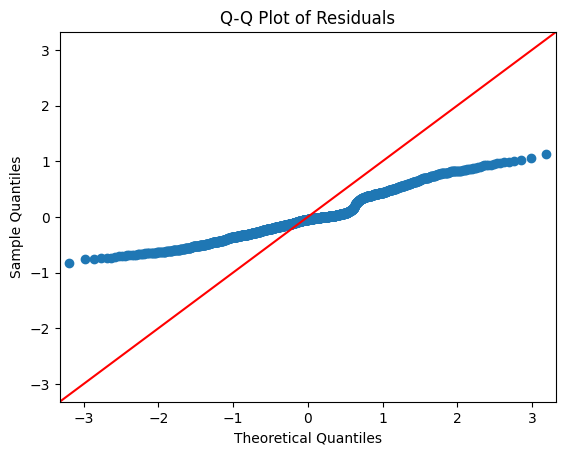

In [11]:
# Q-Q plot for residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

### Assessing Autocorrelation

Autocorrelation isn't expected as the training data doesn't contain any specific ordering or time-dependent features, but to mathematically verify this assumption I chose to use the Durbin-Watson test as recommended by this [source](https://godatadrive.com/blog/basic-guide-to-test-assumptions-of-linear-regression-in-r). As we can see, the statistical result is very close to 2 indicating no autocorrelation of the residuals 

In [12]:
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 2.0303859975104173


In [13]:
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'r-squared: {r_squared}')

# Get and print the intercept and coefficients
print(f'Intercept: {model.intercept_}')
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)

Mean Squared Error: 0.144863896699363
r-squared: 0.2577051725233155
Intercept: 0.1967488941940923
                                  Feature  Coefficient
0                                  gender     0.004368
1                           SeniorCitizen     0.040866
2                                 Partner    -0.008168
3                              Dependents    -0.028623
4                            PhoneService    -0.020915
5                        PaperlessBilling     0.038583
6                            TotalCharges    -0.141557
7                       MultipleLines_Yes     0.057059
8                      OnlineSecurity_Yes    -0.050570
9                        OnlineBackup_Yes    -0.020100
10                   DeviceProtection_Yes     0.009051
11                        TechSupport_Yes    -0.047414
12                        StreamingTV_Yes     0.061197
13                    StreamingMovies_Yes     0.060129
14            InternetService_Fiber optic     0.190909
15                    

Intuitively we can tell by the values of the coefficients that this model did not perform well in determining Churn. Having a negative relationship with TotalCharges implies that as the company increases the total cost of the service, the customer is less likely to churn. As much as the company would love that, it doesn't seem very realistic.

In terms of model performance, we know that our values can range between 0 and 1 and thus if we calculate the RMSE using the Mean-Squared Error of approximately 0.142 (RMSE = √MSE = √0.142) we can see the model's prediction on average is ≈ 0.377 off from the actual value. Combined with an R-Squared that only explains about 27.2% of the variance in the model, this leads us to the conclusion that the model is underfitting the data.

In [14]:
drops = []
for i in range(len(coefficients)):
    if abs(coefficients['Coefficient'][i]) < 0.05:
        drops.append(coefficients["Feature"][i])

X_new = X.drop(columns=drops)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)
model_n = LinearRegression().fit(X_train_n, y_train_n)
y_pred_n = model_n.predict(X_test_n)
residuals_n = y_test_n - y_pred_n

mse_n = mean_squared_error(y_test_n, y_pred_n)
r_squared_n = r2_score(y_test_n, y_pred_n)

print(f'Mean Squared Error: {mse_n}')
print(f'r-squared: {r_squared_n}')

# Get and print the intercept and coefficients
print(f'Intercept: {model_n.intercept_}')
coefficients_n = pd.DataFrame({
    'Feature': X_new.columns,
    'Coefficient': model_n.coef_
})
print(coefficients_n)

Mean Squared Error: 0.14507004069018126
r-squared: 0.2566488733239548
Intercept: 0.18344079872216973
                          Feature  Coefficient
0                    TotalCharges    -0.151511
1               MultipleLines_Yes     0.058614
2              OnlineSecurity_Yes    -0.059832
3                 StreamingTV_Yes     0.063331
4             StreamingMovies_Yes     0.064392
5     InternetService_Fiber optic     0.208107
6              InternetService_No    -0.150819
7               Contract_One year    -0.140442
8               Contract_Two year    -0.125237
9  PaymentMethod_Electronic check     0.077878


## Logistic Regression

For Logistic Regression, we have already assed our data for linearity, multicollinearity and independence of observations. For meeting the requirement of a large sample size, there isn't much we can do as these are the customer data we have, unless this is only a portion of our customer base. Then, perhaps using a larger dataset that encompasses more of our customers would be acceptable. 

In [15]:
model = LogisticRegression(max_iter=500).fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'f1-score: {f1_val}')

# Get and print the intercept and coefficients
print(f'Intercept: {model.intercept_}')
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_.flatten()
})
print(coefficients)

Accuracy: 0.7953091684434968
f1-score: 0.5873925501432665
Intercept: [-1.38421796]
                                  Feature  Coefficient
0                                  gender     0.024509
1                           SeniorCitizen     0.168928
2                                 Partner    -0.098222
3                              Dependents    -0.241748
4                            PhoneService    -0.315411
5                        PaperlessBilling     0.276424
6                            TotalCharges    -0.683195
7                       MultipleLines_Yes     0.308351
8                      OnlineSecurity_Yes    -0.393659
9                        OnlineBackup_Yes    -0.155467
10                   DeviceProtection_Yes     0.058570
11                        TechSupport_Yes    -0.321965
12                        StreamingTV_Yes     0.349152
13                    StreamingMovies_Yes     0.324435
14            InternetService_Fiber optic     1.025387
15                     InternetServic

We can see that the accuracy of this model is close to 80% which doesn't seem too bad. However our f1 score still indicates that this model is underfitting the data and needs improvement

### Logistic GAM

For GAM, again we have already met the assumptions for linearity, multicollinearity, sample size and know that we have violated homoscedasticity. The results below show almost identical performance to Logistic Regression and thus we can reach the same conclusion.


In [25]:
gam = LogisticGAM(lam=0.1) 
gam.fit(X_train, y_train)

# Make predictions
y_pred_prob = gam.predict_proba(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'f1-score: {f1_val}')

# Get and print the intercept and coefficients
print(f'Intercept: {model.intercept_}')
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_.flatten()
})
print(coefficients)

Accuracy: 0.7931769722814499
f1-score: 0.5637181409295352
Intercept: [-1.38421796]
                                  Feature  Coefficient
0                                  gender     0.024509
1                           SeniorCitizen     0.168928
2                                 Partner    -0.098222
3                              Dependents    -0.241748
4                            PhoneService    -0.315411
5                        PaperlessBilling     0.276424
6                            TotalCharges    -0.683195
7                       MultipleLines_Yes     0.308351
8                      OnlineSecurity_Yes    -0.393659
9                        OnlineBackup_Yes    -0.155467
10                   DeviceProtection_Yes     0.058570
11                        TechSupport_Yes    -0.321965
12                        StreamingTV_Yes     0.349152
13                    StreamingMovies_Yes     0.324435
14            InternetService_Fiber optic     1.025387
15                     InternetServic

### Discussion

While linear regression was easy to interpret, we can see based on the metrics calculated that the performance of the model was not ideal. This should be expected as the actual data is binary, and linear regression is meant for continuous variables. For both logistic regression and the GAM we saw similar results in terms of accuracy and f1 score, and were able to interpret that both models are underfitting the data. Given that the GAM took longer to run to retrieve the same results as the logistic regression model, if we follow Occam's Razor, we should select logistic regression as the model chosen to predict churn. 

### Citations:

https://godatadrive.com/blog/basic-guide-to-test-assumptions-of-linear-regression-in-r

https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity#Testing